## Q-Learning with epsilon-greedy action selection

Investigate how Q-learning behaves on Cliff World (Page 132 of textbook)

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import agent
import cliffworld_env
from tqdm import tqdm
import pickle
from matplotlib.colors import hsv_to_rgb

In [2]:
plt.rcParams.update({'font.size':15})
plt.rcParams.update({'figure.figsize':[10,5]})

In [3]:
class QLearningAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        '''
        Setup for agent called when the experiment first starts
        '''
        
        # store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info['num_actions']
        self.num_states = agent_init_info['num_states']
        self.epsilon = agent_init_info['epsilon']
        self.step_size = agent_init_info['step_size']
        self.discount = agent_init_info['discount']
        self.rand_generator = np.random.RandomState(agent_info['seed'])
        
        #create an array for action-value estimates and initialize to zero
        self.q = np.zeros((self.num_states,self.num_actions))
        
    def agent_start(self, state):
        '''
        The first method called when the episode starts, called after the
        environment starts.
        '''
        # Choose action using epsilon greedy.
        
        current_q = self.q[state,:]
        if self.rand_generator.rand()<self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        
        return action
    
    def agent_step(self, reward, state):
        '''
        A step taken by the agent
        '''
        
        #choose action using epsilon greedy
        
        current_q = self.q[state,:]
        
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        #perform an update
        self.q[self.prev_state, self.prev_action] += self.step_size*(reward+self.discount*np.max(current_q)
                                                                     -self.q[self.prev_state,self.prev_action])
        self.prev_state = state
        self.prev_action = action
        
        return action
    
    def agent_end(self, reward):
        '''
        Run when the agent terminates.
        '''
        self.q[self.prev_state,self.prev_action] += self.step_size*(reward-self.q[self.prev_state,self.prev_action])
        
    def argmax(self, q_values):
        '''
        argmax with random tie-breaking
        '''
        
        top = float("-inf")
        ties = []
        
        for i in range(len(q_values)):
            if q_values[i]>top:
                top = q_values[i]
                ties = []
            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)        

### Experiment

In [4]:
env = cliffworld_env.Environment
all_reward_sums = [] #Contains sum of rewards during episodes
all_state_visits = [] # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions":4,"num_states":48,"epsilon":0.1,"step_size":0.5,"discount":1.0}
env_info = {}
num_runs = 100
num_episodes = 500
rsa_first_episode = [] # reward state action for first episode
rsa_second_episode = [] # reward state action for first episode
rsa_last_episode = [] # reward state action for last episode
for run in tqdm(range(num_runs)):
    agent_info['seed'] = run
    rl_glue = RLGlue(env,QLearningAgent)
    rl_glue.rl_init(agent_info,env_info)
    reward_sums = []
    state_visits = np.zeros(48)
    for episode in range(num_episodes):
        if run==0 and episode==0:
            state, action = rl_glue.rl_start()
            rsa_first_episode.append([0.0,state,action]) # for visualization
            state_visits[state] +=1
            is_terminal = False
            while not is_terminal:
                reward, state, action, is_terminal = rl_glue.rl_step()
                rsa_first_episode.append([reward,state,action]) # for visualization
            state_visits[state] += 1
        elif run==0 and episode==1:
            state, action = rl_glue.rl_start()
            rsa_second_episode.append([0.0,state,action]) # for visualization
            state_visits[state] +=1
            is_terminal = False
            while not is_terminal:
                reward, state, action, is_terminal = rl_glue.rl_step()
                rsa_second_episode.append([reward,state,action]) # for visualization
            state_visits[state] += 1
        elif episode>2 and episode < num_episodes - 10:
            rl_glue.rl_episode(0)
        else:
            # Runs an episode while keeping track of visited states
            state, action = rl_glue.rl_start()
            if run==num_runs-1 and episode == num_episodes-9:
                    rsa_last_episode.append([0.0,state,action]) # for visualization
            state_visits[state] +=1
            is_terminal = False
            while not is_terminal:
                reward, state, action, is_terminal = rl_glue.rl_step()
                if run==num_runs-1 and episode == num_episodes-1:
                    rsa_last_episode.append([reward,state,action]) # for visualization
                state_visits[state] += 1
        reward_sums.append(rl_glue.rl_return())
    all_reward_sums.append(reward_sums)
    all_state_visits.append(state_visits)

100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


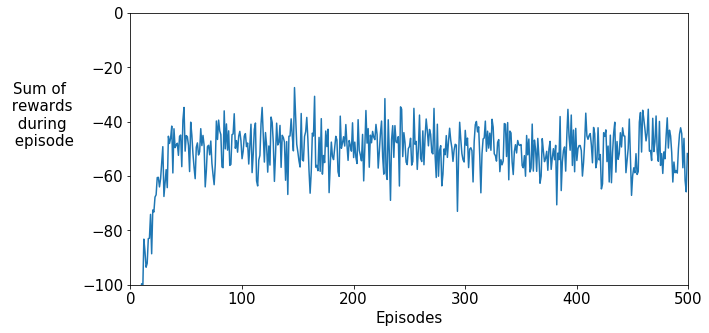

In [5]:
plt.plot(np.mean(all_reward_sums,axis=0))
plt.xlabel('Episodes')
plt.ylabel('Sum of \n rewards \n during \n episode', rotation=0, labelpad = 40)
plt.xlim(0,500)
plt.ylim(-100,0)
plt.legend()
plt.show()

### Gridworld Animation

Ref: https://github.com/lgvaz/blog/blob/master/rl_intro.ipynb

In [6]:
def change_range(values, vmin=0, vmax=1):
    start_zero = values - np.min(values)
    return (start_zero / (np.max(start_zero) + 1e-7)) * (vmax - vmin) + vmin

In [7]:
class GridWorld:
    terrain_color = dict(normal=[127/360, 0, 96/100],
                         objective=[26/360, 100/100, 100/100],
                         cliff=[247/360, 92/100, 70/100],
                         player=[344/360, 93/100, 100/100])
        
    def __init__(self):
        self.player = None
        self._create_grid()  
        self._draw_grid()
        
    def _create_grid(self, initial_grid=None):
        self.grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
        self._add_objectives(self.grid)
        
    def _add_objectives(self, grid):
        grid[0, 1:11] = self.terrain_color['cliff']
        grid[0, 11] = self.terrain_color['objective']
        
    def _draw_grid(self):
        self.fig, self.ax = plt.subplots(figsize=(12, 4))
        self.ax.grid(which='minor')       
        self.q_texts = [self.ax.text(*self._id_to_position(i)[::-1], '0',
                                     fontsize=11, verticalalignment='center', 
                                     horizontalalignment='center') for i in range(12 * 4)]     
         
        self.im = self.ax.imshow(hsv_to_rgb(self.grid), cmap='terrain',
                                 interpolation='nearest', vmin=0, vmax=1)        
        self.ax.set_xticks(np.arange(12))
        self.ax.set_xticks(np.arange(12) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(4))
        self.ax.set_yticks(np.arange(4) - 0.5, minor=True)
        
    def reset(self):
        self.player = (0, 0)        
        return self._position_to_id(self.player)
    
    def step(self, action):
        # Possible actions
        if action == 0 : #right  min(new_state[1]+1,self.cols-1)
            self.player = (self.player[0],min(self.player[1]+1, 11))
        if action == 1 : # down max(new_state[0]-1,0)
            self.player = (max(self.player[0] - 1, 0),self.player[1])
        if action == 2 : #left max(new_state[1]-1,0)
            self.player = (self.player[0],max(self.player[1]-1, 0))
        if action == 3: #up min(new_state[0]+1, self.rows-1)
            self.player = (min(self.player[0]+1, 3),self.player[1])
            
        # Rules
        if all(self.grid[self.player] == self.terrain_color['cliff']):
            reward = -100
            done = True
        elif all(self.grid[self.player] == self.terrain_color['objective']):
            reward = 0
            done = True
        else:
            reward = -1
            done = False
            
        return self._position_to_id(self.player), reward, done
    
    def _position_to_id(self, pos):
        ''' Maps a position in x,y coordinates to a unique ID '''
        return pos[0] * 12 + pos[1]
    
    def _id_to_position(self, idx):
        return (idx // 12), (idx % 12)
        
    def render(self, q_values=None, action=None, max_q=False, colorize_q=False):
        assert self.player is not None, 'You first need to call .reset()'  
        
        if colorize_q:
            assert q_values is not None, 'q_values must not be None for using colorize_q'            
            grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
            values = change_range(np.max(q_values, -1)).reshape(4, 12)
            grid[:, :, 1] = values
            self._add_objectives(grid)
        else:            
            grid = self.grid.copy()
            
        grid[self.player] = self.terrain_color['player']       
        self.im.set_data(hsv_to_rgb(grid))
               
        if q_values is not None:
            xs = np.repeat(np.arange(12), 4)
            ys = np.tile(np.arange(4), 12)  
            
            for i, text in enumerate(self.q_texts):
                if max_q:
                    q = max(q_values[i])    
                    txt = '{:.2f}'.format(q)
                    text.set_text(txt)
                else:                
                    actions = ['R', 'D', 'L', 'U']
                    txt = '\n'.join(['{}: {:.2f}'.format(k, q) for k, q in zip(actions, q_values[i])])
                    text.set_text(txt)
                
        if action is not None:
            self.ax.set_title(action, color='r', weight='bold', fontsize=32)

        plt.pause(0.1)

In [8]:
actions = ['RIGHT', 'DOWN', 'LEFT', 'UP']

In [9]:
def play(q_values,rsa):
    env = GridWorld()
    state = env.reset()
    done = False
    i=0
    for _,state,action in rsa[:-1]:    
        # Select action
        env.step(action)
        if rsa[i+1][1]==0 and i>0:
            state = env.reset()
        i+=1
        env.render(q_values=q_values, action=actions[action], colorize_q=False,max_q=False)

#### First episode

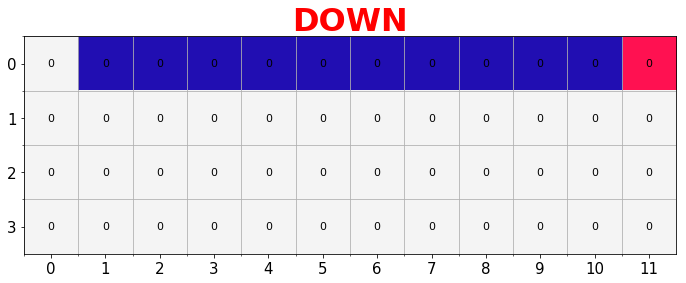

In [10]:
play(None,rsa_first_episode)

#### Second episode

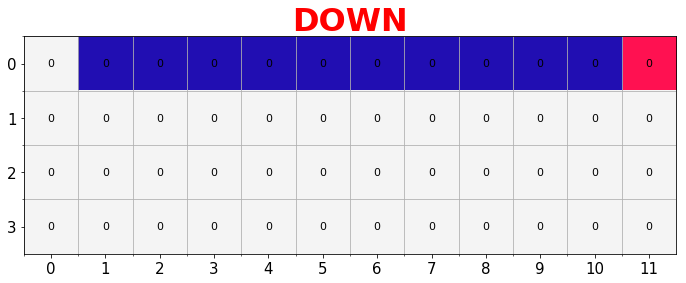

In [11]:
play(None,rsa_second_episode)

#### Last episode

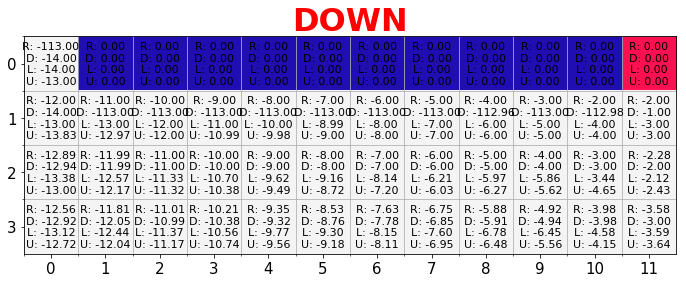

In [12]:
q_values = rl_glue.agent.q
play(q_values, rsa_last_episode)